<h1>Email recipient recommendation</h1>

<i>Thomas Boudou, Guillaume Richard, Antoine Simoulin</i>

<p style="text-align: justify">It was shown that at work, employees frequently forget to include one or more recipient(s) before sending a message. Conversely, it is common that some recipients of a given message were actually not intended to receive the message. To increase productivity and prevent information leakage, the needs for effective <b>email recipient recommendation</b> systems are thus pressing.

In this challenge, you are asked to develop such a system, which, given the content and the date of a message, recommends a list of <b>10 recipients ranked by decreasing order of relevance</b>.</p>

<h2>Requirements</h2>

In [1]:
%matplotlib inline
import random
import operator
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import networkx as nx
import warnings
warnings.filterwarnings("ignore")
import seaborn.apionly as sns

In [2]:
# colors for plot
blue_light = '#029aed'
orange_med = '#ff5722'
green_light = '#63a600'
gray_light = '#666666'

<h2>Load data</h2>

In [3]:
# load some of the files
path_to_data = 'data/'
training = pd.read_csv(path_to_data + 'training_set.csv', sep=',', header=0, encoding='utf-8')
training_info = pd.read_csv(path_to_data + 'training_info.csv', sep=',', header=0, encoding='utf-8')#, index_col = ['mid'])
test = pd.read_csv(path_to_data + 'test_set.csv', sep=',', header=0, encoding='utf-8')
test_info = pd.read_csv(path_to_data + 'test_info.csv', sep=',', header=0, encoding='utf-8')#, index_col = ['mid'])

In [4]:
# correcting error on dataset
training_info.date.replace(to_replace='0001', value='2001', inplace=True, regex=True)
training_info.date.replace(to_replace='0002', value='2002', inplace=True, regex=True)

In [5]:
# setting date format to datetime type
training_info['date'] =  pd.to_datetime(training_info['date'], format='%Y-%m-%d %H:%M:%S.%f')

<h2>Latent Dirichlet Allocation</h2>

In [7]:
# http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-topics-extraction-with-nmf-lda-py

from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(training_info.body)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(training_info.body)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Extracting tf-idf features for NMF...
done in 9.886s.
Extracting tf features for LDA...
done in 8.924s.
Fitting the NMF model with tf-idf features, n_samples=2000 and n_features=1000...
done in 7.927s.

Topics in NMF model:
Topic #0:
ect hou 2000 ectcc subject forwarded pm 09 08 sara 03 shackleton 01 lon 12 11 04 10 corp 07
Topic #1:
com http aol www 2000 mail net hotmail enron doc yahoo email subject cc bass mailto report 08 energy forwarded
Topic #2:
know let just need good think going like don ll want week time work make today talk sure day did
Topic #3:
sara 713 shackleton 646 853 3490 fax smith america north phone 1400 texas eb shackletonenron street 5620 3801ahouston 77002713 corp
Topic #4:
enron na corp enronxgate et ees 2001 enroncc communications enron_development 05 jeff richard subject 04 james pm mark shapiro cc
Topic #5:
thanks lynn help send kim attached sara mike jim questions michelle info list deal need update file marie copy let
Topic #6:
filename 26 02 chris john ger

<h2>Data overview</h2>

In [6]:
print(training.shape)
print(training_info.shape)
print(test.shape)
print(test_info.shape)

(125, 2)
(43613, 4)
(125, 2)
(2362, 3)


In [7]:
training.head()
# for each of the 125 senders ('sender') in the training set, contains a list of message IDs ('mids')

,sender,mids
0,karen.buckley@enron.com,158713 158697 200301 158679 278595 298162 2002...
1,amr.ibrahim@enron.com,215241 3437 215640 3506 191790 3517 3520 3562 ...
2,andrea.ring@enron.com,270705 270706 270707 270708 270709 270710 2707...
3,sylvia.hu@enron.com,111444 111422 183084 111412 111347 110883 1105...
4,phillip.platter@enron.com,327074 327384 327385 264443 274124 274125 2741...


In [8]:
df_ar = np.empty((training_info.shape[0],2), dtype=object)
training_arr = training.values
i = 0
k = 0

while i < training_info.shape[0]:
    for mid in training_arr[k,1].split():
        df_ar[i] = [training_arr[k,0],int(mid)]
        i+=1
    k+=1
    
df = pd.DataFrame(df_ar, columns=['sender','mid'])
df.head()

,sender,mid
0,karen.buckley@enron.com,158713
1,karen.buckley@enron.com,158697
2,karen.buckley@enron.com,200301
3,karen.buckley@enron.com,158679
4,karen.buckley@enron.com,278595


In [9]:
training_info = training_info.merge(df, on='mid')

In [12]:
training_info.to_csv('trainining_w_sender.csv', sep='\t', encoding='utf-8')

In [10]:
training_info['nb_dest'] = 0
training_info_arr = training_info.values # np array object (faster for loop compared to dataframe)
for i in range(training_info_arr.shape[0]):
    count = 0
    for dest in training_info_arr[i,3].split():
        count +=1
        training_info_arr[i,5]=count
training_info = pd.DataFrame(training_info_arr, columns=['mid','date','body','recipients','sender', 'nb_rec']) # np array to dataframe

In [11]:
training_info_class = pd.DataFrame(training_info[['nb_rec','sender']], columns=['nb_rec', 'sender'])
training_info_class.head()

,nb_rec,sender
0,9,christian.yoder@enron.com
1,22,heather.dunton@enron.com
2,3,janel.guerrero@enron.com
3,2,tim.belden@enron.com
4,4,christian.yoder@enron.com


In [12]:
# defines features for classification
training_info_class['Fwd'] = training_info.body.apply(lambda x: 'fwd' in x.lower() or 'forwarded' in x.lower()).astype(int)
training_info_class['To'] = training_info.body.apply(lambda x: 'to:' in x.lower() or 'amto' in x.lower()).astype(int)
training_info_class['Len'] = training_info.body.apply(lambda x: len(x)).astype(int)
training_info_class['FYI'] = training_info.body.apply(lambda x: 'fyi' in x.lower()).astype(int)
training_info_class['From'] = training_info.body.apply(lambda x: 'from:' in x.lower()).astype(int)
training_info_class['Subject'] = training_info.body.apply(lambda x: 'subject:' in x.lower()).astype(int)
training_info_class['Calendar'] = training_info.body.apply(lambda x: 'calendar entry' in x.lower()).astype(int)
training_info_class['Re'] = training_info.body.apply(lambda x: 're:' in x.lower()).astype(int)
training_info_class['Question_marked'] = training_info.body.apply(lambda x: '?' in x.lower()).astype(int)
training_info_class['All'] = training_info.body.apply(lambda x: 'all:' in x.lower()).astype(int)
training_info_class['alpha'] = training_info.body.apply(lambda x: sum(1 for c in x if c.isalnum())).astype(int) # Returns true if all bytes in the sequence are alphabetical ASCII characters or ASCII decimal digits and the sequence is not empty, false otherwise.
training_info_class['Upper'] = training_info.body.apply(lambda x: sum(1 for c in x if c.isupper())).astype(int)

In [13]:
training_info.head()
# each row contains the ID ('mid'), date, body, and recipients of an email from the training set. 

,mid,date,body,recipients,sender,nb_rec
0,60,2000-07-25 08:14:00,Legal has been assessing the risks of doing bl...,robert.badeer@enron.com murray.o neil@enron.co...,christian.yoder@enron.com,9
1,66,2000-08-03 02:56:00,Attached is a spreadsheet to estimate export f...,kim.ward@enron.com robert.badeer@enron.com mur...,heather.dunton@enron.com,22
2,74,2000-08-15 05:37:00,Kevin/Bob: Here is a quick rundown on the cons...,robert.badeer@enron.com john.massey@enron.com ...,janel.guerrero@enron.com,3
3,80,2000-08-20 14:12:00,check this out and let everyone know what s up...,robert.badeer@enron.com jeff.richter@enron.com,tim.belden@enron.com,2
4,83,2000-08-22 08:17:00,Further to your letter to us (addressed to Mr....,pgillman@schiffhardin.com kamarlantes@calpx.co...,christian.yoder@enron.com,4


In [14]:
training_info_class.head()

,nb_rec,sender,Fwd,To,Len,FYI,From,Subject,Calendar,Re,Question_marked,All,alpha,Upper
0,9,christian.yoder@enron.com,0,0,1575,0,0,0,0,0,0,0,1254,28
1,22,heather.dunton@enron.com,0,0,50,0,0,0,0,0,0,0,42,1
2,3,janel.guerrero@enron.com,0,0,7372,0,0,0,0,0,0,0,6051,400
3,2,tim.belden@enron.com,0,0,62,0,0,0,0,0,0,0,37,0
4,4,christian.yoder@enron.com,0,0,442,0,0,0,0,0,0,0,356,20


In [15]:
X = pd.get_dummies(training_info_class.sender).values
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_PCA = pca.fit_transform(X)
training_info_class_arr = training_info_class.values
X_data = np.hstack((training_info_class_arr[:,2:],X_PCA))
y_train = training_info_class_arr[:,0]
print(y_train[:5])
is_small = np.array(y_train < 20).astype(np.int)
print(is_small[:5])

#X_train_df = pd.DataFrame(X_data, columns=['Fwd','To','Len', 'FYI','From','Subject','Calendar','Re','Question_marked','All','alpha','Upper','send1','send2','send3']) # np array to dataframe
#X_train_df.head()

[9 22 3 2 4]
[1 0 1 1 1]


In [18]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def mare_score(y_true, y_pred):
    return np.sum(np.abs((y_true - y_pred))) #0/1 loss

X_train, X_test, y_train, y_test = train_test_split(X_data, is_small, test_size=0.2)
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('%i errors over %i mails (%.1f%% error rate)' %(mare_score(y_test, y_pred),y_pred.shape[0],100*mare_score(y_test, y_pred)/y_pred.shape[0]))

264 errors over 8723 mails (3.0% error rate)


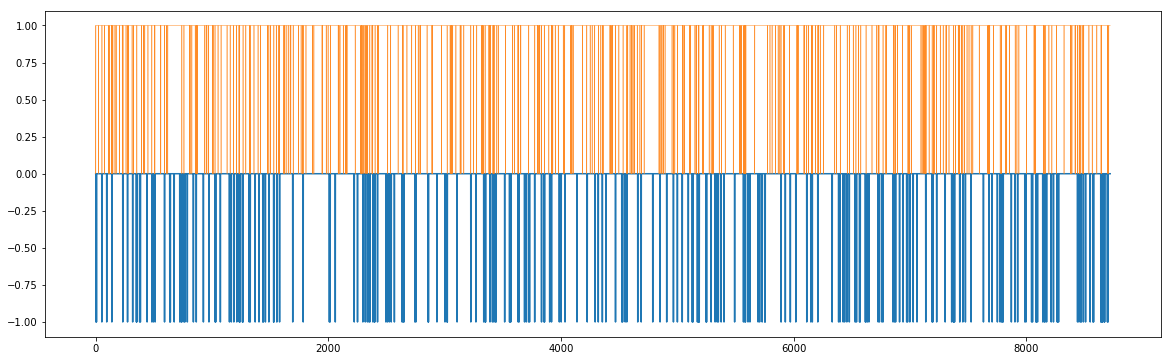

In [19]:
fig, ax1 = plt.subplots(figsize=[20,6])
plt.plot(-np.abs(y_pred-y_test))
plt.plot(y_pred, linewidth=0.5, alpha=0.9)
plt.show()

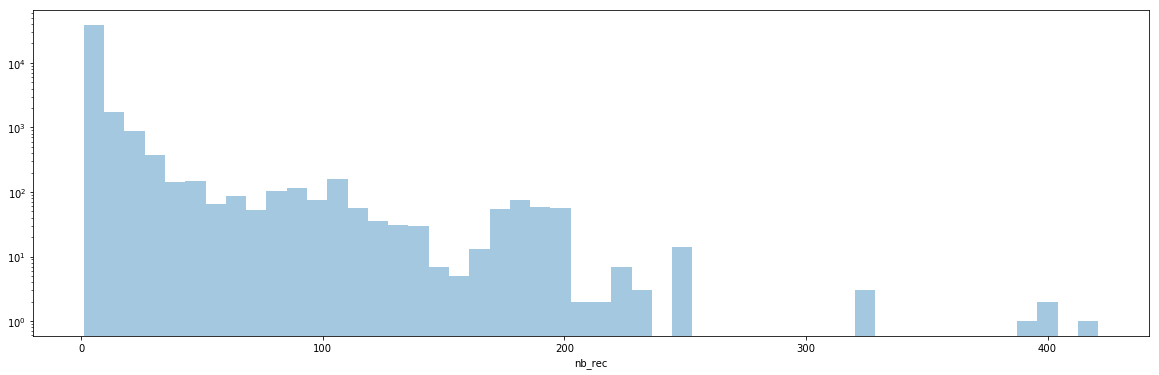

In [20]:
f, axes = plt.subplots(figsize=[20,6])
axes.set_yscale('log')
sns.distplot(training_info_class.nb_rec, kde=False)
plt.show()

In [16]:
# convert training set to dictionary
# each sender is described with a key and is associated a list of message IDs (mids)
emails_ids_per_sender = {}
for index, series in training.iterrows():
    row = series.tolist()
    sender = row[0]
    ids = row[1:][0].split(' ')
    emails_ids_per_sender[sender] = ids

# save all unique sender names
all_senders = emails_ids_per_sender.keys()

# create address book with frequency information for each user
address_books = {}
i = 0

for sender, ids in emails_ids_per_sender.items():
    recs_temp = []
    for my_id in ids:
        recipients = training_info[training_info['mid']==int(my_id)]['recipients'].tolist()
        recipients = recipients[0].split(' ')
        # keep only legitimate email addresses
        recipients = [rec for rec in recipients if '@' in rec]
        recs_temp.append(recipients)
    # flatten    
    recs_temp = [elt for sublist in recs_temp for elt in sublist]
    # compute recipient counts
    rec_occ = dict(Counter(recs_temp))
    # order by frequency
    sorted_rec_occ = sorted(rec_occ.items(), key=operator.itemgetter(1), reverse = True)
    # save
    address_books[sender] = sorted_rec_occ

In [17]:
print(training_info.date.min())
print(training_info.date.max())

1998-12-21 05:29:00
2002-03-08 14:09:25


In [18]:
print(test_info.date.min())
print(test_info.date.max())

2001-11-02 05:25:29
2002-06-24 13:15:28


In [19]:
print('number of mails : %s' %training_info.shape[0])
print('number of groups of contacts : %s' %training_info.recipients.unique().shape[0])

number of mails : 43613
number of groups of contacts : 14162


In [20]:
# convert training set to dictionary
# each sender is described with a key and is associated a list of message IDs (mids)
emails_ids_per_sender = {}
for index, series in training.iterrows():
    row = series.tolist()
    sender = row[0]
    ids = row[1:][0].split(' ')
    emails_ids_per_sender[sender] = ids

# save all unique sender names
all_senders = emails_ids_per_sender.keys()

In [21]:
nb_mails = {}
nb_groups = {}
for sender in all_senders:
    training_info_sender= training_info[training_info['sender']==sender]
    nb_mails[sender] = training_info_sender.shape[0]
    nb_groups[sender] = training_info_sender.recipients.unique().shape[0]

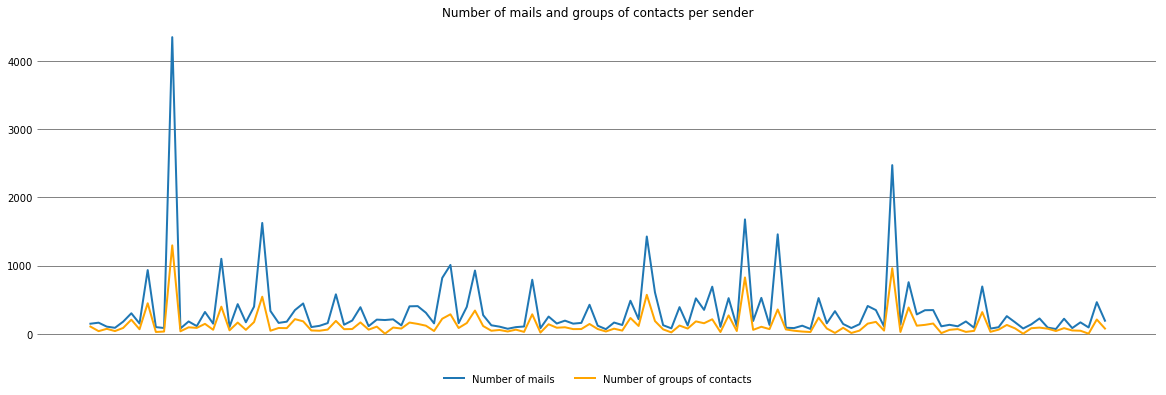

In [24]:
fig, ax1 = plt.subplots(figsize=[20,6])
ax1.plot([nb_mails[d] for d in all_senders], label='Number of mails', linewidth = 2)
ax1.plot([nb_groups[d] for d in all_senders], label='Number of groups of contacts', color='orange', linewidth = 2)

# ax1.set_xlabel('senders')
# ax1.set_ylabel('number of mails')
# ax1.set_xticks(range(len(all_senders)))
# ax1.set_xticklabels([d for d in all_senders], rotation='vertical')
ax1.set_xticks(range(0))
ax1.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    left = 'on',
    right = 'off',
    labelleft='on', # labels along the bottom edge are off
    color = gray_light) 

ax1.set_xticklabels('')

# remove border of the graph
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# set grid
ax1.grid(True, which = 'both', axis='y', color=gray_light, linestyle='-')

h1, l1 = ax1.get_legend_handles_labels()
plt.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
plt.title('Number of mails and groups of contacts per sender')
fig.savefig('plots/number_mails_groups.png',bbox_inches='tight', transparent=False)
plt.show()

sender : michael.tribolet@enron.com communicated with 82 groups


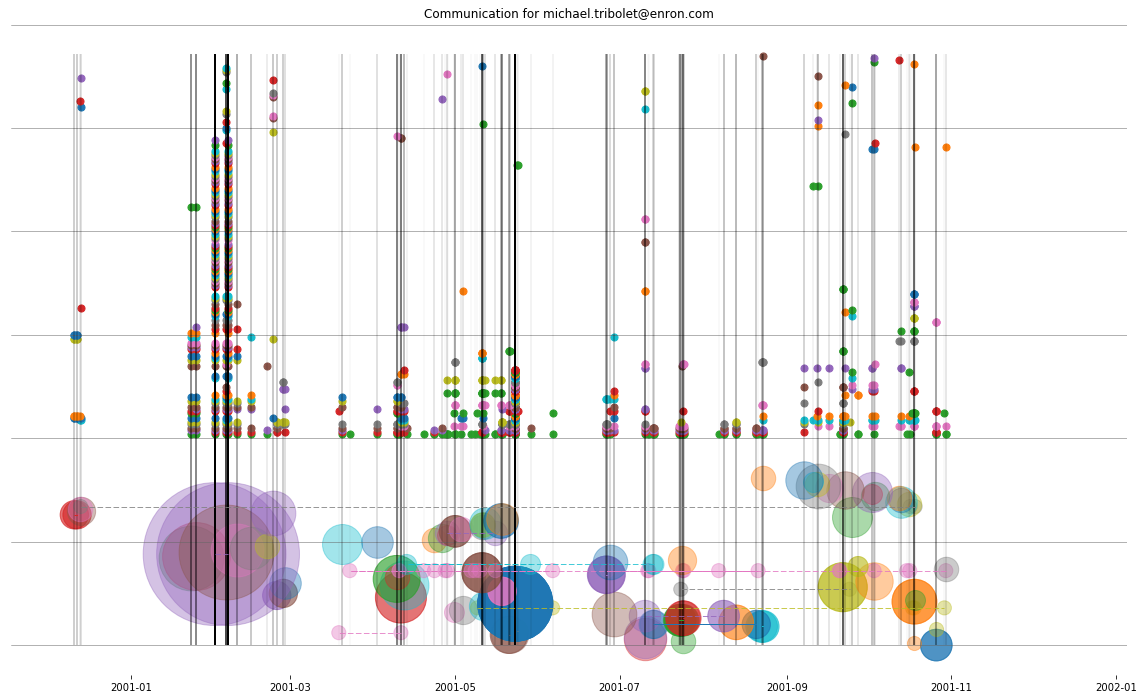

In [25]:
sender = random.choice(list(emails_ids_per_sender.keys()))
#sender = 'paul.y barbo@enron.com'
training_info_sender= training_info[training_info['sender']==sender]
training_info_sender.set_index(training_info_sender.date, inplace=True)
training_info_sender['msg']=0
training_info_sender['rec']=0
print('sender : %s communicated with %i groups' %(sender, training_info_sender.recipients.unique().shape[0]))

fig, ax1 = plt.subplots(figsize=[20,12])
# remove border of the graph
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax1.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    left = 'off',
    right = 'off',
    labelleft='off', # labels along the bottom edge are off
    color = gray_light) 

# set grid
ax1.grid(True, which = 'both', axis='y', color=gray_light, linestyle='-', linewidth=0.5)

i = 0
for groups in training_info_sender.recipients.unique():
    training_info_sender.ix[training_info_sender.recipients==groups,'msg']=i
    i+=1
    x = training_info_sender[training_info_sender.recipients==groups].msg
    y = [pd.to_datetime(d) for d in training_info_sender[training_info_sender.recipients==groups].date]
    z = [float(d)*200 for d in training_info_sender[training_info_sender.recipients==groups].nb_rec]
    ax1.scatter(y,x,s=z,marker='o',alpha=0.4)
    ax1.plot(training_info_sender[training_info_sender.recipients==groups].msg,linestyle='--',linewidth=0.8)

i+=20
ymax=len(address_books[sender])+20+len(training_info_sender.recipients.unique())
for rec, values in address_books[sender]:
    training_info_sender.ix[training_info_sender.recipients.str.contains(str(rec)),'rec']=i
    i+=1
    x = training_info_sender[training_info_sender.recipients.str.contains(str(rec))].rec
    y = [pd.to_datetime(d) for d in training_info_sender[training_info_sender.recipients.str.contains(str(rec))].date]
    ax1.scatter(y,x,s=50,marker='o')

    for date in y:
        plt.vlines(x=date, ymin=0, ymax=ymax, linestyles='-', linewidth=0.05)
        
plt.title('Communication for %s' %sender)
fig.savefig('plots/sender_communication_%s.png' %sender,bbox_inches='tight', transparent=False)
plt.show()

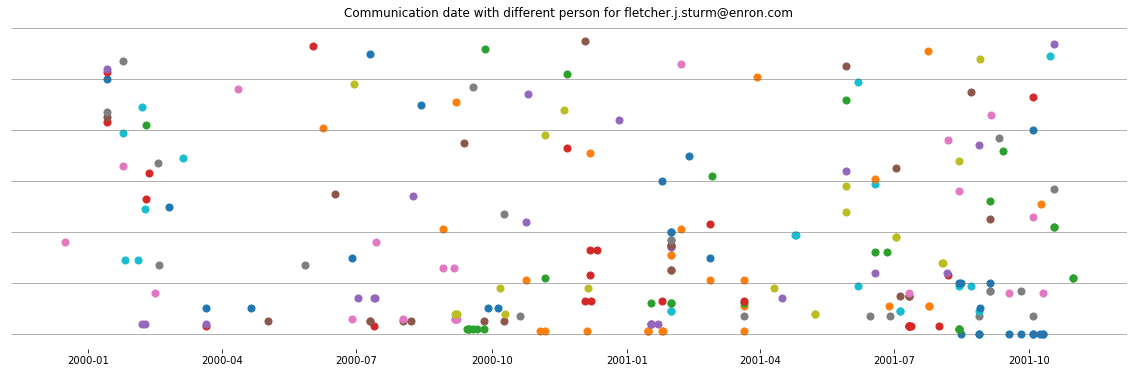

In [26]:
sender = random.choice(list(emails_ids_per_sender.keys()))
sender = 'fletcher.j.sturm@enron.com'
training_info_sender= training_info[training_info['sender']==sender]
training_info_sender.set_index(training_info_sender.date, inplace=True)
training_info_sender['rec']=0

fig, ax1 = plt.subplots(figsize=[20,6])
# remove border of the graph
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax1.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    left = 'off',
    right = 'off',
    labelleft='off', # labels along the bottom edge are off
    color = gray_light) 

# set grid
ax1.grid(True, which = 'both', axis='y', color=gray_light, linestyle='-', linewidth=0.5)

i = 0
for rec, values in address_books[sender]:
    training_info_sender.ix[training_info_sender.recipients.str.contains(str(rec)),'rec']=i
    i+=1
    x = training_info_sender[training_info_sender.recipients.str.contains(str(rec))].rec
    y = [pd.to_datetime(d) for d in training_info_sender[training_info_sender.recipients.str.contains(str(rec))].date]
    plt.scatter(y,x,s=50,marker='o')
plt.title('Communication date with different person for %s' %sender)
fig.savefig('plots/sender_communication_%s.png' %sender,bbox_inches='tight', transparent=False)
plt.show()

Number of mails sent by sender : 77


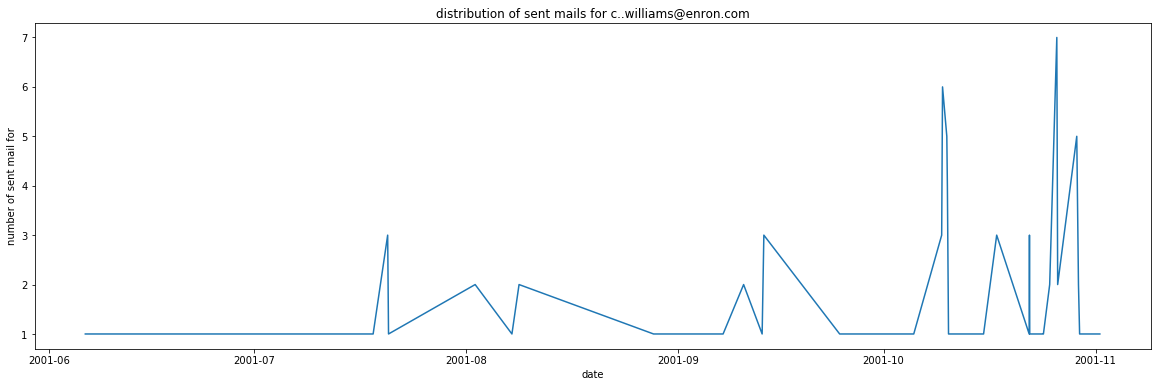

In [27]:
sender = random.choice(list(emails_ids_per_sender.keys()))
print('Number of mails sent by sender : %s' %training_info[training_info['sender']==sender].shape[0])

# compute number of message per hour for each candidate
training_info_sender= training_info[training_info['sender']==sender]
training_info_sender = training_info_sender[['date','mid']]
training_info_sender['Nb_messages'] = 1
training_info_sender['dt2'] = training_info_sender['date'].values.astype('<M8[h]')
training_info_sender = training_info_sender[['dt2','Nb_messages']].groupby(['dt2'], as_index=False).sum()
training_info_sender.set_index(training_info_sender.dt2, inplace=True)

# distribution sent mails
fig = plt.figure(figsize=[20,6])
plt.plot(training_info_sender.Nb_messages)
plt.ylabel('number of sent mail for')
plt.xlabel('date')
plt.title('distribution of sent mails for %s'%sender)
plt.show()

In [28]:
test_info.head()

,mid,date,body
0,1577,2001-11-19 06:59:51,Note: Stocks of heating oil are very high for...
1,1750,2002-03-05 08:46:57,"Kevin Hyatt and I are going for ""sghetti"" at S..."
2,1916,2002-02-13 14:17:39,This was forwarded to me and it is funny. - Wi...
3,2094,2002-01-22 11:33:56,I will be in to and happy to assist too. I ma...
4,2205,2002-01-11 07:12:19,Thanks. I needed a morning chuckle.


In [29]:
test.head()

,sender,mids
0,karen.buckley@enron.com,298389 332383 298390 284071 366982 81773 81791...
1,amr.ibrahim@enron.com,48260 48465 50344 48268 50330 48237 189979 189...
2,andrea.ring@enron.com,366364 271168 271172 271167 271189
3,sylvia.hu@enron.com,134931 134856 233549 233517 134895 233584 3736...
4,phillip.platter@enron.com,274220 274225 274215 274223 274214 274207 2742...


In [30]:
test.head()
# for each of the 125 senders ('sender') in the test set, contains a list of message IDs ('mids'). 
# For each of these messages, the recipients are to be predicted

,sender,mids
0,karen.buckley@enron.com,298389 332383 298390 284071 366982 81773 81791...
1,amr.ibrahim@enron.com,48260 48465 50344 48268 50330 48237 189979 189...
2,andrea.ring@enron.com,366364 271168 271172 271167 271189
3,sylvia.hu@enron.com,134931 134856 233549 233517 134895 233584 3736...
4,phillip.platter@enron.com,274220 274225 274215 274223 274214 274207 2742...


In [31]:
df_ar = np.empty((test_info.shape[0],2), dtype=object)
test_arr = test.values
i = 0
k = 0

while i < test_info.shape[0]:
    for mid in test_arr[k,1].split():
        df_ar[i] = [test_arr[k,0],int(mid)]
        i+=1
    k+=1
    
df = pd.DataFrame(df_ar, columns=['sender','mid'])
df.head()

,sender,mid
0,karen.buckley@enron.com,298389
1,karen.buckley@enron.com,332383
2,karen.buckley@enron.com,298390
3,karen.buckley@enron.com,284071
4,karen.buckley@enron.com,366982


In [32]:
test_info = test_info.merge(df, on='mid')

In [33]:
test_info.head()
# test_info : each row contains the ID ('mid'), date, and body of an email from the test set. 

,mid,date,body,sender
0,1577,2001-11-19 06:59:51,Note: Stocks of heating oil are very high for...,lorna.brennan@enron.com
1,1750,2002-03-05 08:46:57,"Kevin Hyatt and I are going for ""sghetti"" at S...",julie.armstrong@enron.com
2,1916,2002-02-13 14:17:39,This was forwarded to me and it is funny. - Wi...,julie.armstrong@enron.com
3,2094,2002-01-22 11:33:56,I will be in to and happy to assist too. I ma...,julie.armstrong@enron.com
4,2205,2002-01-11 07:12:19,Thanks. I needed a morning chuckle.,julie.armstrong@enron.com


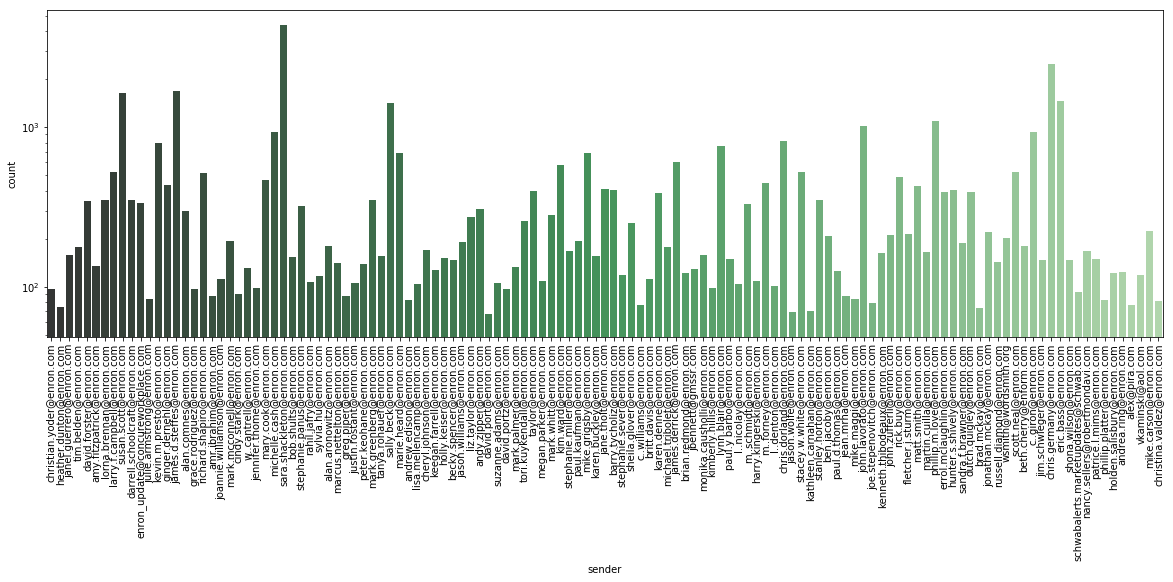

In [23]:
f, axes = plt.subplots(figsize=[20,6])
axes.set_yscale('log')
sns.countplot(x='sender', data=training_info, palette="Greens_d");
plt.xticks(rotation=90)
plt.show()

In [24]:
training_info.sender.value_counts()

sara.shackleton@enron.com                4350
chris.germany@enron.com                  2473
james.d.steffes@enron.com                1677
susan.scott@enron.com                    1625
eric.bass@enron.com                      1458
sally.beck@enron.com                     1426
phillip.m.love@enron.com                 1099
john.lavorato@enron.com                  1009
michelle.cash@enron.com                   934
c..giron@enron.com                        927
chris.dorland@enron.com                   819
kevin.m.presto@enron.com                  792
lynn.blair@enron.com                      756
marie.heard@enron.com                     693
mike.grigsby@enron.com                    690
james.derrick@enron.com                   606
kim.ward@enron.com                        578
stacey.w.white@enron.com                  526
scott.neal@enron.com                      523
larry.f.campbell@enron.com                522
richard.shapiro@enron.com                 519
rick.buy@enron.com                

In [34]:
# example mail
print('--------------- dest ---------------')
for dest in training_info['recipients'][0].split():
    print(dest)
print('------------------------------------')
print('\n'+training_info['body'][0])

--------------- dest ---------------
robert.badeer@enron.com
murray.o
neil@enron.com
tim.belden@enron.com
elizabeth.sager@enron.com
carla.hoffman@enron.com
jeff.richter@enron.com
chris.stokley@enron.com
valarie.sabo@enron.com
------------------------------------

Legal has been assessing the risks of doing block forward trades as financial and for now, subject to future changes that may be required  as discussions with the CAPX legal experts continue,  we can state the basic rules as follows:It is okay to do up to 50% of  our Block Forward business as financial.It is very important to monitor this 50% level very closely and we should not exceed it. We should not rely on the PX to tell us what the level is. We should confirm it ourselves.  A skeptical regulator, looking at PX records should never be able to see that we ever did more than half our block forward business as financial.  One of the legal rules that we must comply with in this area is that there must be a bona fide commercia

In [35]:
# example mail
print('--------------- dest ---------------')
for dest in training_info['recipients'][32774].split():
    print(dest)
print('------------------------------------')
print('\n'+training_info['body'][32774])

--------------- dest ---------------
gbsonnta@utmb.edu
michael.walters@enron.com
jody.crook@enron.com
mjillard@beaconelectric.com
david.baumbach@enron.com
rachel.m.bonilla@ac.com
bryan.hull@enron.com
todagost@utmb.edu
scott.crowell@us.oracle.com
o
neal.winfree@enron.com
jimmy.simien@enron.com
kyle.lilly@enron.com
kevin.bosse@enron.com
eric.bass@enron.com
cbpels@lyondell.com
james.love@msl.redstone.army.mil
------------------------------------

---------------------- Forwarded by Phillip M Love/HOU/ECT on 06/30/2000 07:33 AM ---------------------------Shane.Dobbs@fctg.com on 06/30/2000 07:17:07 AMTo: bigb@sonet.net, plove@enron.com, jmjaked@mindspring.com, dobbsmw@auburn.edu, dobbswn@auburn.edu, beenemm@auburn.educc:  Subject: FW: Rocker- Here this time-----Original Message----- From: Stevenson_Scott Sent: Wednesday, June 28, 2000 9:52 AM To: BIFP TRADERS Subject: FW: Rocker- Here this time > Subject: Rocker > > > > > > > > > The Top 15 Signs John Rocker Is Your Stockbroker > > > > > > 

In [36]:
# example mail
print('--------------- dest ---------------')
for dest in training_info['recipients'][18057].split():
    print(dest)
print('------------------------------------')
print('\n'+training_info['body'][18057])

--------------- dest ---------------
melissa.murphy@enron.com
------------------------------------

Melissa:We agreed to the form of confirm with ConEd last night.  Michael Forte was to send the redraft to Michael Brown.  I haven t seen it yet.  Sounds like there will be a plain vanilla swap also, which should look like (format) the one we did in January.Sara ShackletonEnron North America Corp.1400 Smith Street, EB 3801aHouston, Texas  77002713-853-5620 (phone)713-646-3490 (fax)sara.shackleton@enron.com


In [37]:
# example mail
print('--------------- dest ---------------')
for dest in training_info['recipients'][13248].split():
    print(dest)
print('------------------------------------')
print('\n'+training_info['body'][13248])

--------------- dest ---------------
kevin.hyatt@enron.com
------------------------------------

Amazing that TW has not one but TWO people doing this job.Your tree-saving efforts are admirable.Kevin Hyatt06/21/2000 10:56 AMTo: Susan Scott/ET&S/Enron@ENRONcc:  Subject: Transwestern FERC tariff pagesSee, all you have to do is ask---------------------- Forwarded by Kevin Hyatt/ET&S/Enron on 06/21/2000 10:56 AM ---------------------------   	Enron Energy Services		From:  Naomi Bourg                           06/21/2000 09:55 AM	To: Glen Hass/ET&S/Enron@ENRONcc: Kevin Hyatt/ET&S/Enron@Enron, Barbara Bischoff/ET&S/Enron@ENRON Subject: Transwestern FERC tariff pagesGlen,Please see Kevin s note below.  I agree that we should keep separate distribution lists for Transwestern.  I have had other requests like Kevin s.  As a temporary and imperfect solution, I have marked the labels either All Holders or Filings.   Dennis Lee is currently working to put Northern and Transwestern mailing lists on 

In [38]:
# example mail
n = int(random.random()*training_info.shape[0])
print('mail n°%i\n'%n)
print('--------------- dest ---------------')
for dest in training_info['recipients'][n].split():
    print(dest)
print('------------------------------------')
print('\n'+training_info['body'][n])

mail n°26458

--------------- dest ---------------
no.address@enron.com
------------------------------------

Robert J. Higgins202-828-2272HigginsR@dsmo.com


<h2>Features exctraction and definition</h2>

In [39]:
# nltk.download()

In [21]:
import nltk
import string

from collections import Counter

def get_tokens(text):
    # removre capitals letters.
    lowers = text.lower()
    # remove the punctuation using the character deletion step of translate
    no_punctuation = lowers.translate(None, string.punctuation)
    #no_punctuation = lowers.translate(str.maketrans('','',string.punctuation))
    tokens = nltk.word_tokenize(lowers)
    return tokens

exemple ='Jassem,Attached is the latest update for the DPC project. A printed copy of project photos is being forwarded to you seperately. If you have any questions, please feel free to call me at 713 345-5855.Best Regards,Paul'
tokens = get_tokens(exemple)#training_info.body[32774])
count = Counter(tokens)
print(count.most_common(100))

TypeError: translate() takes exactly one argument (2 given)

In [41]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Antoine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Antoine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [84]:
type(tokens)

list

In [85]:
from nltk.corpus import stopwords
# These are uninformative, so let's remove the stop words.
tokens = get_tokens(training_info.body[32774])
filtered = [w for w in tokens if not w in stopwords.words('english')]
count = Counter(filtered)
print(count.most_common(100))

[('rocker', 4), ('subject', 3), ('white', 3), ('money', 3), ('term', 2), ('15', 2), ('fw', 2), ('06302000', 2), ('stocks', 2), ('stuart', 1), ('top', 1), ('short', 1), ('shanedobbsfctgcom', 1), ('profitable', 1), ('bread', 1), ('possum', 1), ('futures', 1), ('wall', 1), ('threatening', 1), ('hood', 1), ('punch', 1), ('7', 1), ('convince', 1), ('0733', 1), ('dobbswnauburnedu', 1), ('10', 1), ('tell', 1), ('time', 1), ('nest', 1), ('shares', 1), ('nasdaq', 1), ('lovehouect', 1), ('tries', 1), ('bigbsonetnet', 1), ('misreading', 1), ('signs', 1), ('elvis', 1), ('kid', 1), ('called', 1), ('ends', 1), ('stock', 1), ('suddenly', 1), ('browningferris', 1), ('kick', 1), ('village', 1), ('stupid', 1), ('bitch', 1), ('portfolio', 1), ('beenemmauburneducc', 1), ('mitsubishi', 1), ('rally', 1), ('egg', 1), ('want', 1), ('stevensonscott', 1), ('suggesting', 1), ('foreign', 1), ('ploveenroncom', 1), ('14', 1), ('6', 1), ('beverages', 1), ('talking', 1), ('john', 1), ('pans', 1), ('2000', 1), ('trade

In [86]:
from nltk.stem.porter import *
# We can also do stemming using NLTK using a Porter Stemmer.
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

stemmer = PorterStemmer()
stemmed = stem_tokens(filtered, stemmer)
count = Counter(stemmed)
print(count.most_common(100))

[('rocker', 4), ('subject', 3), ('white', 3), ('stock', 3), ('money', 3), ('short', 2), ('term', 2), ('15', 2), ('fw', 2), ('invest', 2), ('06302000', 2), ('threaten', 2), ('stuart', 1), ('top', 1), ('commemor', 1), ('keep', 1), ('shanedobbsfctgcom', 1), ('elvi', 1), ('ralli', 1), ('bread', 1), ('possum', 1), ('wall', 1), ('compani', 1), ('dump', 1), ('hood', 1), ('punch', 1), ('retir', 1), ('bifp', 1), ('0733', 1), ('dobbswnauburnedu', 1), ('10', 1), ('owner', 1), ('tell', 1), ('time', 1), ('nest', 1), ('nasdaq', 1), ('lovehouect', 1), ('bag', 1), ('7', 1), ('bigbsonetnet', 1), ('show', 1), ('trader', 1), ('kid', 1), ('misread', 1), ('put', 1), ('kick', 1), ('sign', 1), ('bitch', 1), ('prefer', 1), ('convinc', 1), ('beenemmauburneducc', 1), ('someth', 1), ('mitsubishi', 1), ('pick', 1), ('egg', 1), ('want', 1), ('stevensonscott', 1), ('suddenli', 1), ('wonder', 1), ('foreign', 1), ('ploveenroncom', 1), ('villag', 1), ('14', 1), ('tri', 1), ('6', 1), ('messag', 1), ('john', 1), ('plate

In [87]:
# With our cleaned up text, we can now use it for searching, 
# document similarity, or other tasks (clustering, classification) 
# that we'll learn about later on. Unfortunately, 
# calculating tf-idf is not available in NLTK so we'll use another data analysis library, 
# scikit-learn. Scikit-learn has a built in Tf-Idf implementation 
# but we can use NLTK's tokenizer and stemmer to preprocess the text.

import nltk
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

token_dict = {}
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

for i in range(training_info.shape[0]):
    text = training_info.body[i]
    lowers = text.lower()
    no_punctuation = lowers.translate(str.maketrans('','',string.punctuation))
    token_dict[i] = no_punctuation
        
#this can take some time
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
X_train_tfidf = tfidf.fit_transform(token_dict.values())

IndexError: string index out of range

In [ ]:
feature_names = tfidf.get_feature_names()
a = 0
for col in X_train_tfidf.nonzero()[1][:10]:
    print('%20s - %.3f' %(feature_names[col],X_train_tfidf[a, col])) # tf-idf for each term found in document a

<h2>Structures creation and definition</h2>

In [ ]:
# convert training set to dictionary
# each sender is described with a key and is associated a list of message IDs (mids)
emails_ids_per_sender = {}
for index, series in training.iterrows():
    row = series.tolist()
    sender = row[0]
    ids = row[1:][0].split(' ')
    emails_ids_per_sender[sender] = ids

# save all unique sender names
all_senders = emails_ids_per_sender.keys()

# create address book with frequency information for each user
address_books = {}
i = 0

for sender, ids in emails_ids_per_sender.items():
    recs_temp = []
    for my_id in ids:
        recipients = training_info[training_info['mid']==int(my_id)]['recipients'].tolist()
        recipients = recipients[0].split(' ')
        # keep only legitimate email addresses
        recipients = [rec for rec in recipients if '@' in rec]
        recs_temp.append(recipients)
    # flatten    
    recs_temp = [elt for sublist in recs_temp for elt in sublist]
    # compute recipient counts
    rec_occ = dict(Counter(recs_temp))
    # order by frequency
    sorted_rec_occ = sorted(rec_occ.items(), key=operator.itemgetter(1), reverse = True)
    # save
    address_books[sender] = sorted_rec_occ

In [35]:
# print(address_books[list(address_books.keys())[100]])

In [36]:
nb_sender = {}
for sender in list(address_books.keys()):
    expl = [x for x in address_books[sender]] 
    y_val = [x[1] for x in expl]
    nb_sender[sender]= sum(y_val)

In [37]:
# average number of recipients per sender
print(sum(nb_sender[d] for d in nb_sender) / len(nb_sender))

2159.84


In [38]:
top_sender = [sender for sender in nb_sender if nb_sender[sender]>10000]
print('%30s | %15s | %10s'%('sender','nb recipients','nb mails'))
print('%s-+-%s-+-%s'%(30*'-',15*'-',10*'-'))
for sender in top_sender:
    print('%30s | %15i | %10i'%(sender, nb_sender[sender], training_info[training_info['sender']==sender].shape[0]))

                        sender |   nb recipients |   nb mails
-------------------------------+-----------------+-----------
       lorna.brennan@enron.com |           20796 |        347
      cheryl.johnson@enron.com |           27371 |        169
           l..denton@enron.com |           16224 |        101
      ginger.dernehl@enron.com |           27594 |        434


In [39]:
round(4565/1000,0)*1000

5000.0

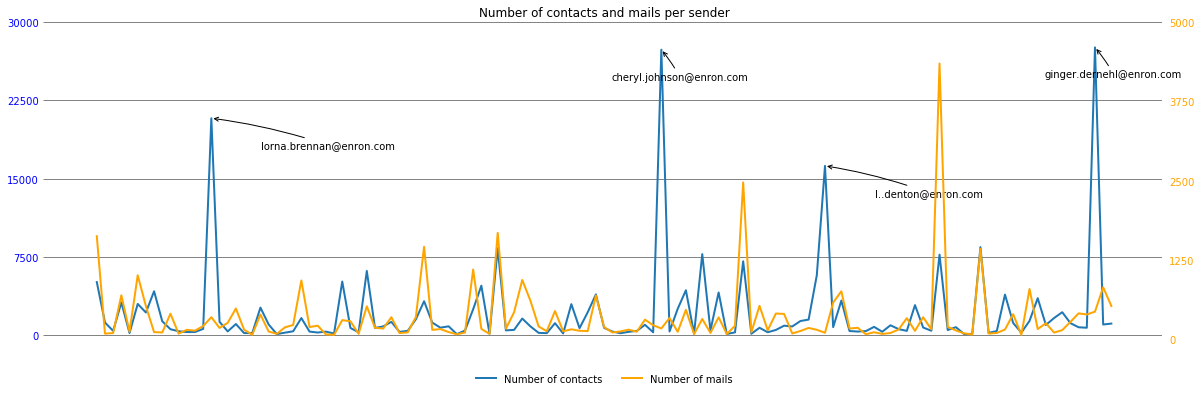

In [40]:
fig, ax1 = plt.subplots(figsize=[20,6])
ax1.plot([nb_sender[d] for d in nb_sender], label='Number of contacts', linewidth=2)

ax1.set_xticks(range(0))
ax1.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    left = 'on',
    right = 'off',
    labelleft='on', # labels along the bottom edge are off
    labelcolor = 'blue',
    color = gray_light) 

ax1.set_xticklabels('')
ax1.set_yticks(np.linspace(0, round(ax1.get_ybound()[1]/10000,0)*10000, 5))

# annotating graph
for sender in top_sender:
    x = [d for d in nb_sender].index(sender)
    y = nb_sender[sender]
    xy = (x,y)
    xtext = ((-1)**top_sender.index(sender))*50
    xytext = (xtext, -30)
    ax1.annotate(sender, xy=xy,  xycoords='data',
                    xytext=xytext, textcoords='offset points',
                    arrowprops=dict(arrowstyle='- >',connectionstyle='arc3,rad=0.05')
                    )

# remove border of the graph
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax2 = ax1.twinx()
ax2.plot([training_info[training_info['sender']==d].shape[0] for d in nb_sender], label='Number of mails', color='orange', linewidth=2)
# ax2.set_ylabel('number of emails')
ax2.set_yticks(np.linspace(0, round(ax2.get_ybound()[1]/1000,0)*1000, 5))

ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    left = 'off',
    right = 'off',
    labelright='on', # labels along the bottom edge are off
    labelcolor = 'orange',
    color = gray_light) 


# set grid
ax1.grid(True, which = 'both', axis='y', color=gray_light, linestyle='-')

# remove border of the graph
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
plt.title('Number of contacts and mails per sender')
fig.savefig('plots/number_contacts_mails.png',bbox_inches='tight', transparent=False)
plt.show()

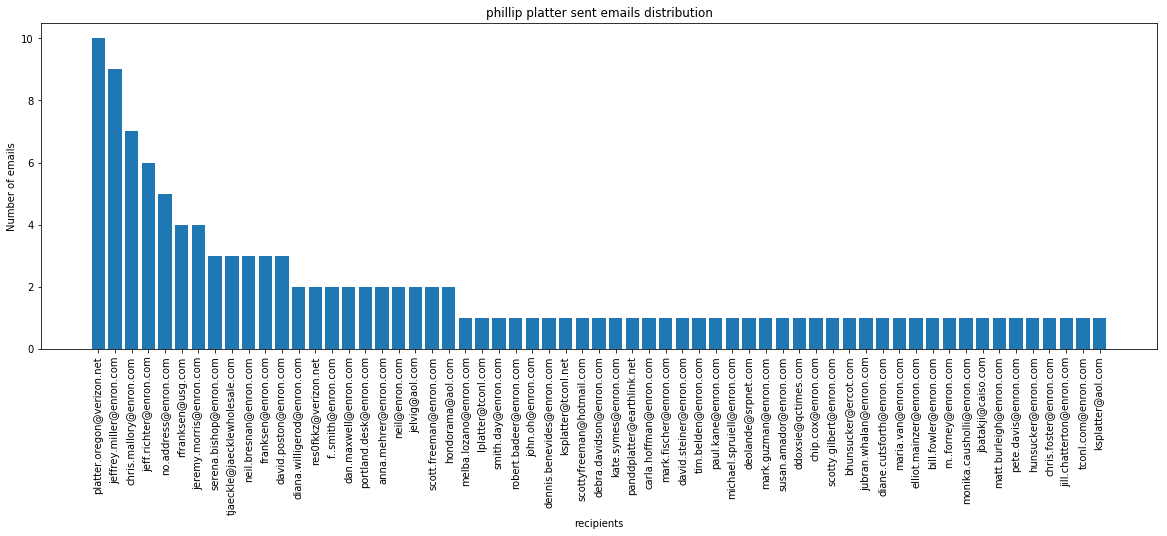

In [41]:
expl = [x for x in address_books['phillip.platter@enron.com']]
x_val = [x[0] for x in expl]
y_val = [x[1] for x in expl]
fig = plt.figure(figsize=[20,6])
plt.bar(range(len(y_val)), y_val, align='center')
plt.xticks(range(len(y_val)), x_val, rotation='vertical')
plt.ylabel('Number of emails')
plt.xlabel('recipients')
plt.title('phillip platter sent emails distribution')
plt.show()

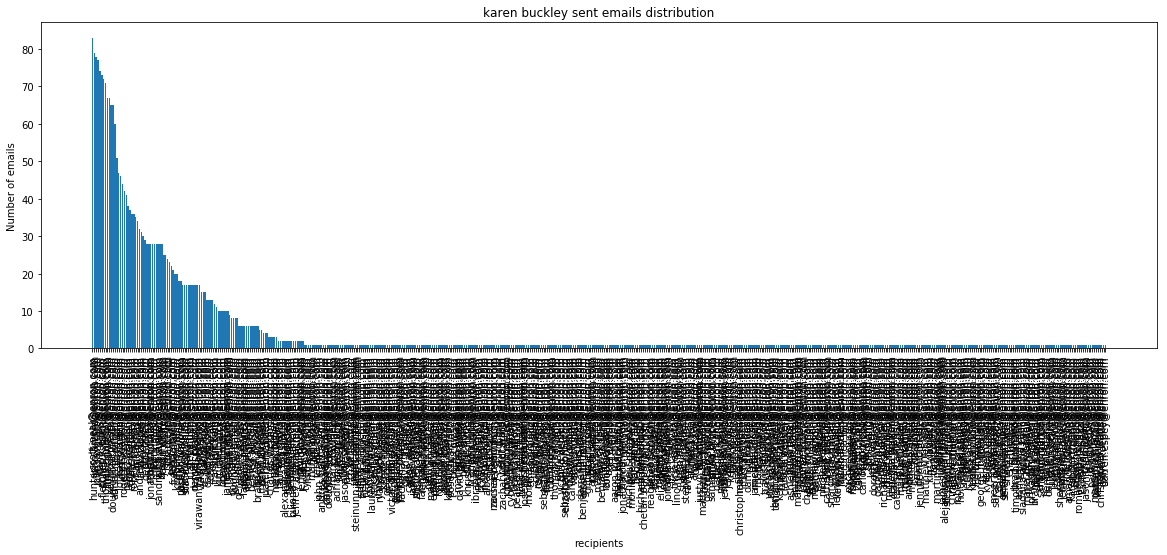

In [42]:
expl = [x for x in address_books['karen.buckley@enron.com']] 
x_val = [x[0] for x in expl]
y_val = [x[1] for x in expl]
fig = plt.figure(figsize=[20,6])
plt.bar(range(len(y_val)), y_val, align='center')
plt.xticks(range(len(y_val)), x_val, rotation='vertical')
plt.ylabel('Number of emails')
plt.xlabel('recipients')
plt.title('karen buckley sent emails distribution')
plt.show()

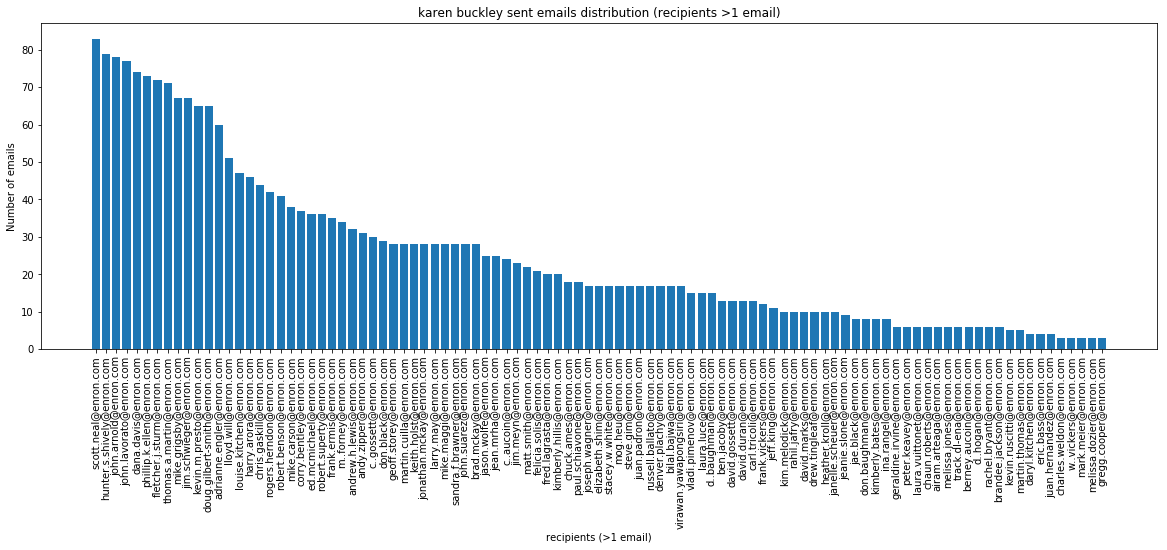

In [43]:
expl = [x for x in address_books['karen.buckley@enron.com'] if x[1]>2] 
x_val = [x[0] for x in expl]
y_val = [x[1] for x in expl]
fig = plt.figure(figsize=[20,6])
plt.bar(range(len(y_val)), y_val, align='center')
plt.xticks(range(len(y_val)), x_val, rotation='vertical')
plt.ylabel('Number of emails')
plt.xlabel('recipients (>1 email)')
plt.title('karen buckley sent emails distribution (recipients >1 email)')
plt.show()

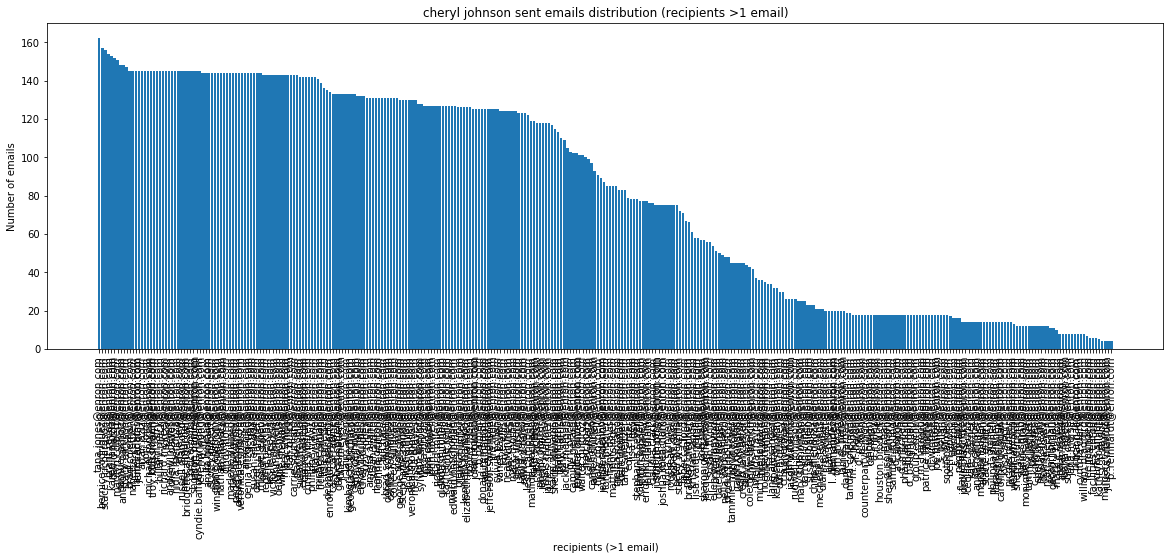

In [44]:
expl = [x for x in address_books['cheryl.johnson@enron.com'] if x[1]>2] 
x_val = [x[0] for x in expl]
y_val = [x[1] for x in expl]
fig = plt.figure(figsize=[20,6])
plt.bar(range(len(y_val)), y_val, align='center')
plt.xticks(range(len(y_val)), x_val, rotation='vertical')
plt.ylabel('Number of emails')
plt.xlabel('recipients (>1 email)')
plt.title('cheryl johnson sent emails distribution (recipients >1 email)')
plt.show()


In [45]:
y_train = training_info.recipients.str.split()
y_train = [x for x in y_train]
print(y_train[0])

['robert.badeer@enron.com', 'murray.o', 'neil@enron.com', 'tim.belden@enron.com', 'elizabeth.sager@enron.com', 'carla.hoffman@enron.com', 'jeff.richter@enron.com', 'chris.stokley@enron.com', 'valarie.sabo@enron.com']


In [46]:
print(X_train_tfidf.shape)

(43613, 275988)


In [47]:
y_train_tfidf = np.zeros((X_train_tfidf.shape[0],len(all_senders)))

<h2>Classifier definition :  cosine similarity computation</h2>

In [51]:
from sklearn.metrics.pairwise import cosine_similarity

X_test_tfidf = {}
X_train_tfidf = {}
token_dict_test = {}
token_dict_train = {}

sender = random.choice(list(emails_ids_per_sender.keys()))

for sender in [sender]:#address_books:
    
    training_info_sender = training_info[training_info.sender==sender]
    for i in range(training_info_sender.shape[0]):
        training_info_sender.reset_index(drop=True, inplace=True)
        text = training_info_sender.body[i]
        lowers = text.lower()
        no_punctuation = lowers.translate(str.maketrans('','',string.punctuation))
        token_dict_train[i] = no_punctuation
        
    #this can take some time
    tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
    X_train_tfidf[sender] = tfidf.fit_transform(token_dict_train.values())
    
    test_info_sender = test_info[test_info.sender==sender]
    for i in range(test_info_sender.shape[0]):
        test_info_sender.reset_index(drop=True, inplace=True)
        text = test_info_sender.body[i]
        lowers = text.lower()
        no_punctuation = lowers.translate(str.maketrans('','',string.punctuation))
        token_dict_test[i] = no_punctuation

    #this can take some time
    X_test_tfidf[sender] = tfidf.transform(token_dict_test.values())
    


feature_names = tfidf.get_feature_names()

n = random.choice(range(X_train_tfidf[sender].shape[0]))
cosine_similarities = cosine_similarity(X_train_tfidf[sender][n],X_train_tfidf[sender])
related_docs_indices = cosine_similarities.argsort()[:,:5]
closest = related_docs_indices[0,0]
inter = [val for val in training_info_sender.recipients[closest].split() if val in training_info_sender.recipients[n].split()]

print('------------------------------------')
print('sender : %s'%sender)
print(related_docs_indices)
print('intsersection dest : '),
print(inter)
print('------------------------------------\n')


print('--------------- dest ---------------')
for dest in training_info_sender.recipients[n].split():
    print(dest)
print('------------------------------------')
print('\n'+training_info_sender.body[n])

print('--------------- dest ---------------')
for dest in training_info_sender.recipients[closest].split():
    print(dest)
print('------------------------------------')
print('\n'+training_info_sender.body[closest])

NameError: name 'string' is not defined

<h2>Submission file</h2>

In [35]:
 # save all unique recipient names    
all_recs = list(set([elt[0] for sublist in address_books.values() for elt in sublist]))

# save all unique user names 
all_users = []
all_users.extend(all_senders)
all_users.extend(all_recs)
all_users = list(set(all_users))

# baselines                        

# will contain email ids, predictions for random baseline, and predictions for frequency baseline
predictions_per_sender = {}

# number of recipients to predict
k = 10

for index, row in test.iterrows():
    name_ids = row.tolist()
    sender = name_ids[0]
    # get IDs of the emails for which recipient prediction is needed
    ids_predict = name_ids[1].split(' ')
    ids_predict = [int(my_id) for my_id in ids_predict]
    random_preds = []
    freq_preds = []
    # select k most frequent recipients for the user
    k_most = [elt[0] for elt in address_books[sender][:k]]
    for id_predict in ids_predict:
        # select k users at random
        random_preds.append(random.sample(all_users, k))
        # for the frequency baseline, the predictions are always the same
        freq_preds.append(k_most)
    predictions_per_sender[sender] = [ids_predict,random_preds,freq_preds]	

# write predictions in proper format for Kaggle                         
path_to_results = 'pred/'

with open(path_to_results + 'predictions_random.txt', 'w') as my_file:
    my_file.write('mid,recipients' + '\n')
    for sender, preds in predictions_per_sender.items():
        ids = preds[0]
        random_preds = preds[1]
        for index, my_preds in enumerate(random_preds):
            my_file.write(str(ids[index]) + ',' + ' '.join(my_preds) + '\n')

with open(path_to_results + 'predictions_frequency.txt', 'w') as my_file:
    my_file.write('mid,recipients' + '\n')
    for sender, preds in predictions_per_sender.items():
        ids = preds[0]
        freq_preds = preds[2]
        for index, my_preds in enumerate(freq_preds):
            my_file.write(str(ids[index]) + ',' + ' '.join(my_preds) + '\n')